## Introduction

This project follows an analysis of a public health study performed in rural Bangladesh van Geen et al. (2002). In this study, wells used for drinking water were analyzed for arsenic contamination and correspondingly labeled as safe or unsafe. The study determined whether households switched the well used for drinking water. Additionally, several variables where measured that were thought to possibly influence the decision of whether or not to switch wells. Here, we will investigate how accurately we can predict whether or not a household will switch wells based on these environmental variables.

## Import libraries

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# plot tree model
import graphviz

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Train-test splits and cross validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn import tree
import xgboost as xgb
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

# Model metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from scipy.stats import uniform, randint


# Logistic function
from scipy.special import expit

## Load the data

This project follows an analysis of a public health study performed in rural Bangladesh (Gelman et al. 2004). In this study, wells used for drinking water were analyzed for arsenic contamination and correspondingly labeled as safe or unsafe. The study determined whether households switched the well used for drinking water. Additionally, several variables where measured that were thought to possibly influence the decision of whether or not to switch wells. Here, we will investigate how accurately we can predict whether or not a household will switch wells based on these environmental variables.

See Gelman et al. (2004) for a discussion of data collection. Briefly, arsenic levels (in hundreds $\mu$g/L) were measured in Araihazar, Bangladesh during the years 1999 - 2000. Additional information was collected by a survey:

1. Whether or not the household switched wells.

2. The distance (in meters) to the closest known safe well.

3. Whether any members of the household are involved in community organizations.

4. The highest education level in the household.


$\rightarrow$ Load the data set contained in the file `wells.csv` and name the data frame `df`.


In [196]:
df = pd.read_csv('https://raw.githubusercontent.com/lbomine/Water-Quality/main/wells.csv')

## Explore the contents of the data sets

$\rightarrow$ Look at the head of the data frame.


In [197]:
df.describe()

,switch,arsenic,dist,assoc,educ
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,0.575166,1.656930,48.331863,0.422848,4.828477
std,0.494400,1.107387,38.478675,0.494093,4.017317
min,0.000000,0.510000,0.387000,0.000000,0.000000
25%,0.000000,0.820000,21.117250,0.000000,0.000000
50%,1.000000,1.300000,36.761499,0.000000,5.000000
75%,1.000000,2.200000,64.041000,1.000000,8.000000
max,1.000000,9.650000,339.531006,1.000000,17.000000


In [198]:
df.head()

,switch,arsenic,dist,assoc,educ
0,1,2.36,16.826000,0,0
1,1,0.71,47.321999,0,0
2,0,2.07,20.966999,0,10
3,1,1.15,21.486000,0,12
4,1,1.10,40.874001,1,14


The variables in the data set are:

1. `switch`: An indicator of whether a household switches wells.

2. `arsenic`: The arsenic level of the household's well (in hundreds $\mu$g/L).

3. `dist`: The distance (in meters) to the closest known safe well.

4. `assoc`: An indicator of whether any members of the household are involved in community organizations.

5. `educ`: The highest education level in the household.
  
  

Check the total unique values and frequency count for each unique value from `assoc`.

In [199]:
df['assoc'].unique()

array([0, 1])

In [200]:
df['assoc'].value_counts()

0    1743
1    1277
Name: assoc, dtype: int64

$\rightarrow$ Check the data types. How many observations are in the data set? How many missing values are there in each column?


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   switch   3020 non-null   int64  
 1   arsenic  3020 non-null   float64
 2   dist     3020 non-null   float64
 3   assoc    3020 non-null   int64  
 4   educ     3020 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 118.1 KB


<Axes: >

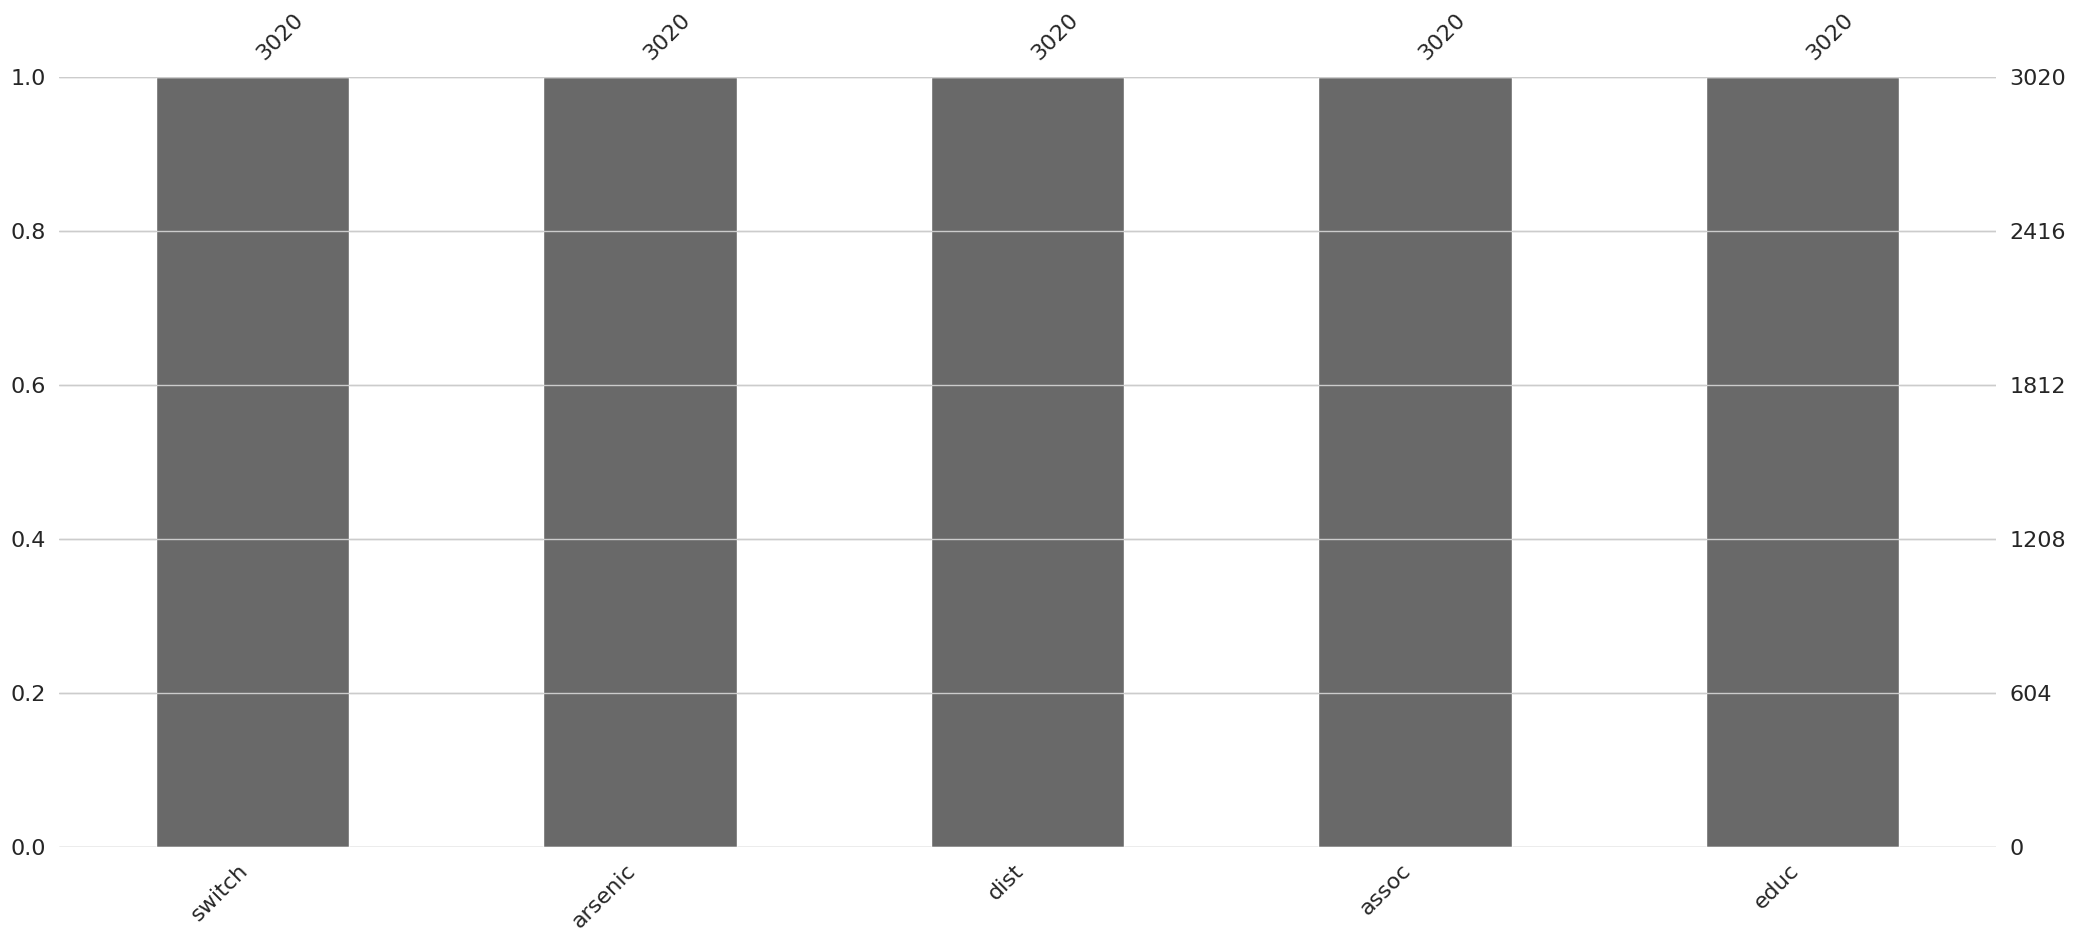

In [202]:
msno.bar(df)

There are no missing values and the data types seem fine.

## Are the data suitable for answering the question?

We want to perform quick exploratory data analysis to determine whether the data are sufficient to answer our question. If the data are not sufficient, we do not want to waste time doing anything that will not be productive.

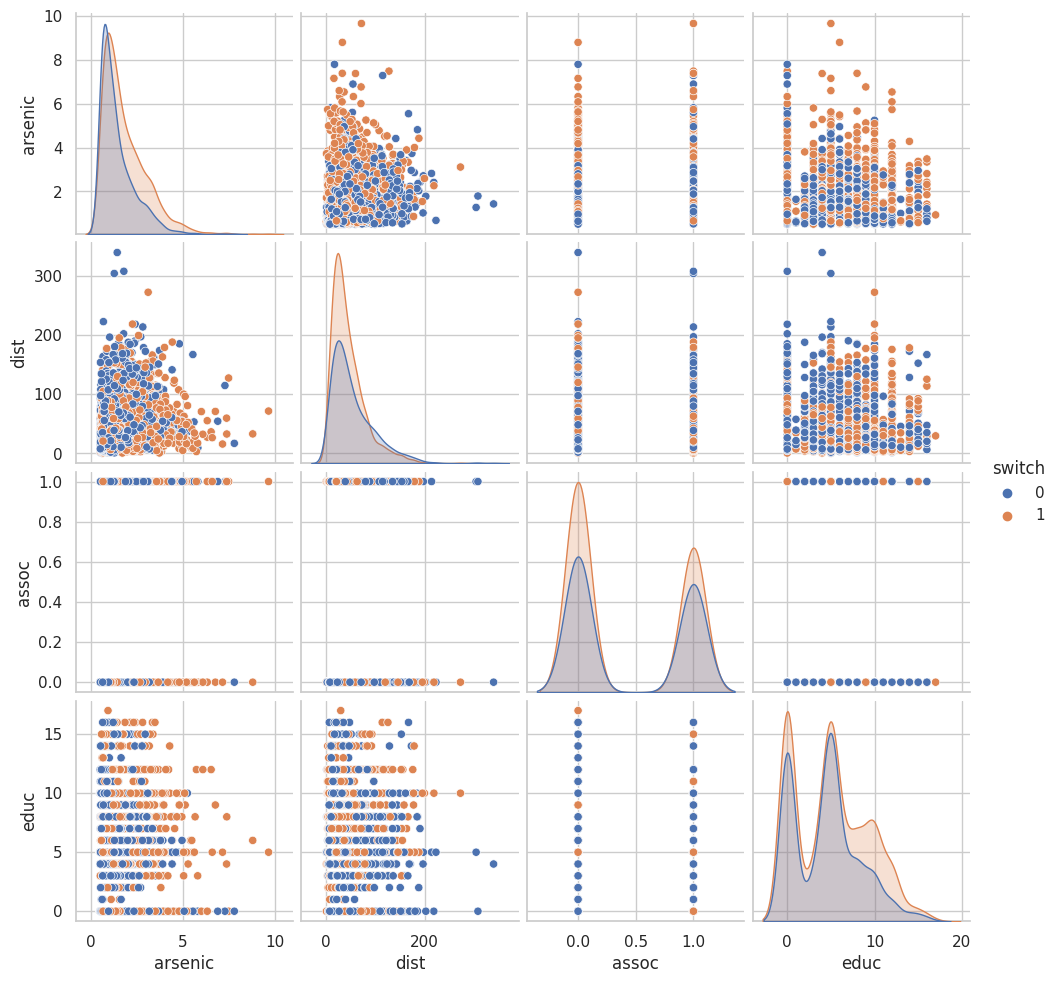

In [203]:
sns.pairplot(df, hue='switch');

There is a balance between switching and not switching in the `assoc` plots. Thus, it is likely there is some relationship between switching and some variables.

## Rename columns or values to follow best practices

In [204]:
df.columns

Index(['switch', 'arsenic', 'dist', 'assoc', 'educ'], dtype='object')

In [205]:
df.rename(columns={'switch':'switch_well', 
                   'dist':'distance_in_meters', 
                   'assoc':'organization_member', 
                   'educ':'education_years'}, inplace=True)

In [206]:
df.head()

,switch_well,arsenic,distance_in_meters,organization_member,education_years
0,1,2.36,16.826000,0,0
1,1,0.71,47.321999,0,0
2,0,2.07,20.966999,0,10
3,1,1.15,21.486000,0,12
4,1,1.10,40.874001,1,14


## Create relevant derived variables as new columns

It is difficult to interpret the coefficient on `distance` in models using it as a predictor because distance is measured in meters. We don't expect much of a change in switching behavior for wells that are 1 meter apart. A more natural measure is 100s of meters. We will scale the distance variable to be in units of 100s of meters.


$\rightarrow$ Convert the distance units into 100s of meters by creating a new column.

In [207]:
df['distance_100_meters'] = df['distance_in_meters']/100

In [208]:
df.head()

,switch_well,arsenic,distance_in_meters,organization_member,education_years,distance_100_meters
0,1,2.36,16.826000,0,0,0.16826
1,1,0.71,47.321999,0,0,0.47322
2,0,2.07,20.966999,0,10,0.20967
3,1,1.15,21.486000,0,12,0.21486
4,1,1.10,40.874001,1,14,0.40874


# Analysis

## Exploratory data analysis

We have two main goals when doing exploratory data analysis. The first is that we want to understand the data set more completely. The second goal is to explore relationships between the variables to help guide the modeling process to answer our specific question.


##### $\rightarrow$ How many switches and non-switches are in the data set?

In [209]:
df['switch_well'].value_counts()

1    1737
0    1283
Name: switch_well, dtype: int64

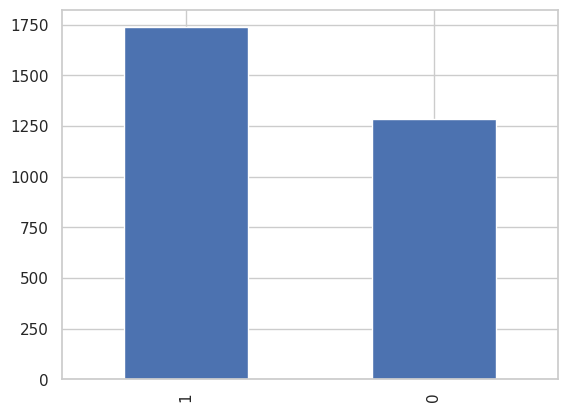

In [210]:
df['switch_well'].value_counts().plot(kind='bar');

#### Plot each input numerical variable vs. switch_well

We want to investigate whether the probability of switching wells is a clear function of the input numerical variables. 

$\rightarrow$ Make scatter plots of `switch_well` vs. each of the input numerical variables. Include jitter to make the points visible.


Plotting the `arsenic` concentration vs. the `switch_well` variable.

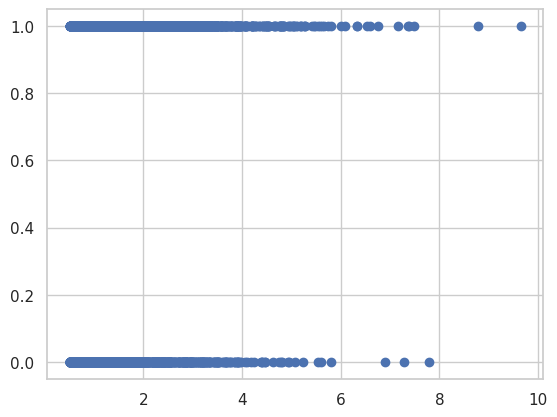

In [211]:
plt.plot(df['arsenic'], df['switch_well'],'o')

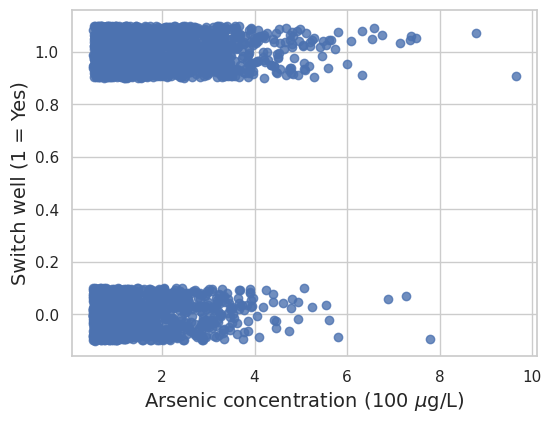

In [212]:
plt.figure(figsize = (6,4.5))

sns.regplot(data = df, x = 'arsenic', y = 'switch_well', ci = None, fit_reg=False, y_jitter = 0.1)

plt.xlabel('Arsenic concentration (100 $\mu$g/L)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

Plotting the distance to the nearest well (in 100 meters) vs. the `switch_well` variable.

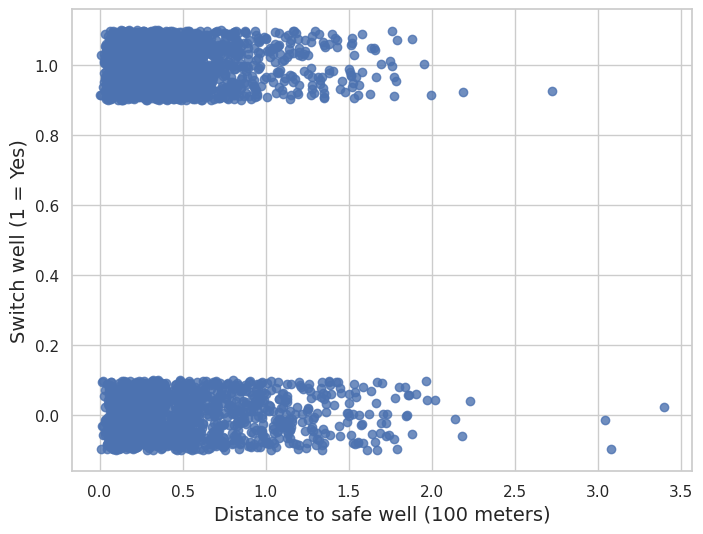

In [213]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'distance_100_meters', y = 'switch_well', ci = None, fit_reg=False, y_jitter = 0.1)

plt.xlabel('Distance to safe well (100 meters)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

Plotting the years of education vs. the `switch_well` variable.

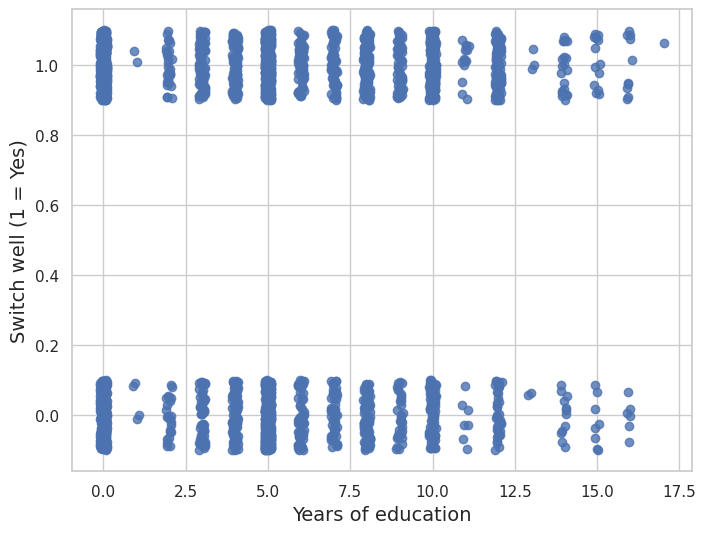

In [214]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'education_years', y = 'switch_well', 
            ci = None, fit_reg=False, y_jitter = 0.1,  x_jitter = 0.1)

plt.xlabel('Years of education', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

$\rightarrow$ Count the number of switches for each value of `organization_member`. Additionally, calculate the proportion of switches for each value of `organization_member`.


In [215]:
df[['switch_well', 'organization_member']].groupby('organization_member').agg(['sum', 'mean'])

switch_well          
                            sum      mean
organization_member                      
0                          1029  0.590361
1                           708  0.554424

## Modeling

Note that linear regression does not produce a suitable model when the output variable is binary.

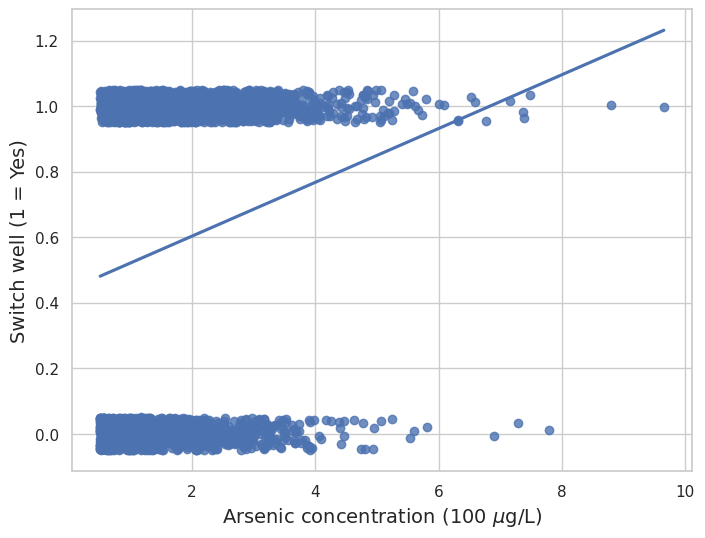

In [216]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'arsenic', y = 'switch_well', ci = None, y_jitter = 0.05)

plt.xlabel('Arsenic concentration (100 $\mu$g/L)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

From the output there are an equal number of people who do not switch compared to those who switched. This suggests that arsenic concentration does not completely influence people's decision and there are other factors that may affect their decision.


### Exploratory models

We will build models using the full data set to understand it more completely.

#### Logistic regression model for all predictors

##### $\rightarrow$ Fit the logistic regression model using all predictors, using the full data set.

In [217]:
X = df.drop(columns=['switch_well', 'distance_in_meters'])

y = df['switch_well']

In [218]:
X.head()

,arsenic,organization_member,education_years,distance_100_meters
0,2.36,0,0,0.16826
1,0.71,0,0,0.47322
2,2.07,0,10,0.20967
3,1.15,0,12,0.21486
4,1.10,1,14,0.40874


Logical regression using Logit function.

In [219]:
log_reg_all = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.646991
         Iterations 5


The model is a resonably good fit for the data with the value of 0.646991. But, we would still want a lower value to better fit.

In [220]:
print(log_reg_all.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3015
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.05106
Time:                        11:09:33   Log-Likelihood:                -1953.9
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 2.321e-44
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1567      0.100     -1.573      0.116      -0.352       0.039
arsenic                 0.4670      0.042     11.226      0.000       0.385       0.549
organization_mem

All predictors except `const` and `organization_member` are statistically significant due to their p-values.

##### $\rightarrow$ Predict the well switching in the data

In [221]:
log_reg_all.predict(sm.add_constant(X))

0       0.688835
1       0.438024
2       0.740122
3       0.667563
4       0.613178
          ...   
3015    0.500176
3016    0.539684
3017    0.545420
3018    0.516202
3019    0.513165
Length: 3020, dtype: float64

Round predicted values to get binary predictions.

In [222]:
pred_switch = round(log_reg_all.predict(sm.add_constant(X)))

In [223]:
pred_switch

0       1.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
3015    1.0
3016    1.0
3017    1.0
3018    1.0
3019    1.0
Length: 3020, dtype: float64

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

In [224]:
class_names = ['no switch', 'switch']

Creating a heatmap to visualize the errors.

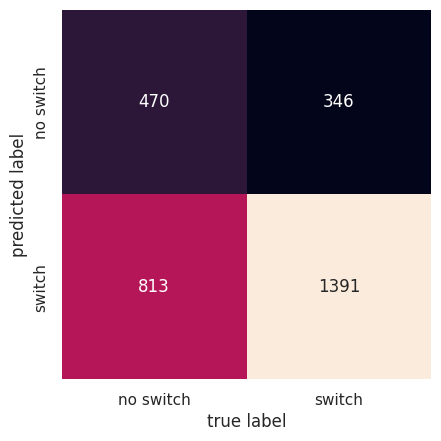

In [225]:
sns.heatmap(confusion_matrix(y, pred_switch).T, square=True, annot=True, cbar=False, 
            fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [226]:
confusion_matrix(y, pred_switch).T

array([[ 470,  346],
       [ 813, 1391]])

In [227]:
print(classification_report(y, pred_switch, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.58      0.37      0.45      1283
      switch       0.63      0.80      0.71      1737

    accuracy                           0.62      3020
   macro avg       0.60      0.58      0.58      3020
weighted avg       0.61      0.62      0.60      3020



The logistic regression model for all predictors  achieved 62% accuracy.

Regarding the "no switch" class:
- The precision of the model for this class was 58%, meaning that 58% of the instances predicted as "no switch" were accurately classified.
- The recall for the "no switch" class was 37%, indicating that only 37% of the actual "no switch" instances were correctly identified by the model.
- The f1-score, which combines precision and recall, for the "no switch" class was 0.45.


Regarding the "switch" class:
- The precision for the "switch" class was 63%, implying that 63% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 80%, meaning that the model accurately identified 80% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.71, representing the harmonic mean of precision and recall.


Calculating the recall for no switch.

In [228]:
470/(470+813)

0.36632891660171474

Calculating the precision for switch.

In [229]:
1391/(1391+346)

0.8008059873344847

The predicted switch are nearly correct because its precision value is 80.1%.

#### Null model

The null model prediction always predicts the value of `switch_well` that occurs most often in the training data.


$\rightarrow$ What is the null model prediction for `switch_well`?





In [230]:
null_prediction = np.ones(np.shape(y))

$\rightarrow$ What is the accuracy of the null model on the full data set?


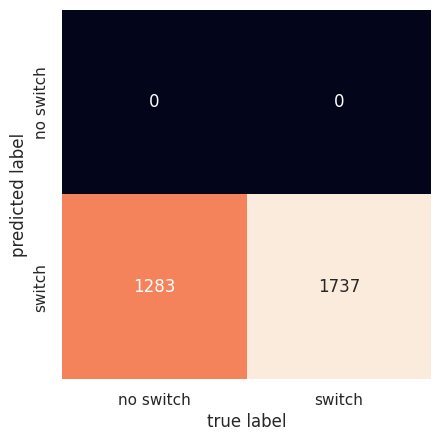

In [231]:
sns.heatmap(confusion_matrix(y, null_prediction).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [232]:
print(classification_report(y, null_prediction, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.00      0.00      0.00      1283
      switch       0.58      1.00      0.73      1737

    accuracy                           0.58      3020
   macro avg       0.29      0.50      0.37      3020
weighted avg       0.33      0.58      0.42      3020



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model achieved a 58% accuracy. So, our full logistic regression model is not that much better.

Regarding the "no switch" class:
- All values are 0.00 indicating the model failed to correctly identify instances belonging to the class.

Regarding the "switch" class:
- The precision for the "switch" class was 58%, implying that 58% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 100%, meaning that the model accurately identified 100% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.73, representing the harmonic mean of precision and recall.
- There are 1737 instances in the "switch" class.

### Simple logistic regression models

#### Fit a model with distance as the predictor




$\rightarrow$ Fit a logistic regression model with distance (in 100s of meters) as the predictor and examine the model.

In [233]:
X = df[['distance_100_meters']]

y = df['switch_well']

In [234]:
log_reg_distance = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4


In [235]:
print(log_reg_distance.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3018
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.01017
Time:                        11:09:34   Log-Likelihood:                -2038.1
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 9.798e-11
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6060      0.060     10.047      0.000       0.488       0.724
distance_100_meters    -0.6219      0.097     -6.383      0.000      -0.813      -0.431


All predictors are statistically significant due to their low p-values of 0.00.

$\rightarrow$ Plot the distance to the nearest well (in 100 meters) vs. the `switch_well` variable and include the logistic regression model.

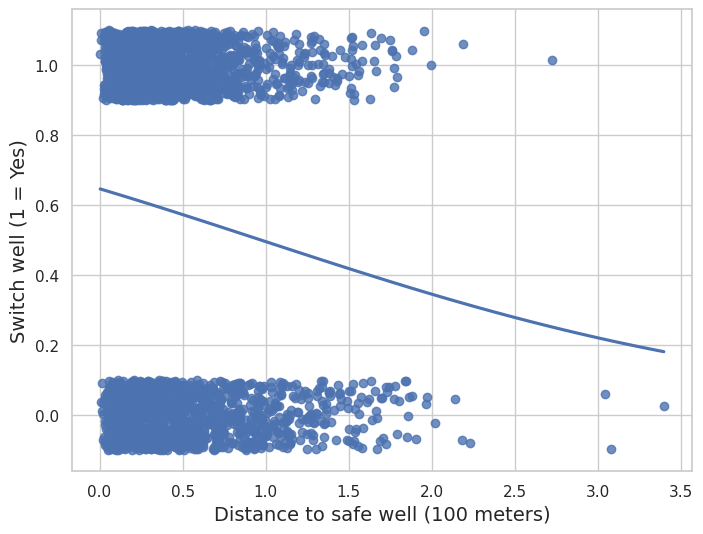

In [236]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, 
            x = 'distance_100_meters', y = 'switch_well', 
            ci = None, y_jitter = 0.1, logistic=True)

plt.xlabel('Distance to safe well (100 meters)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

Calculating estimated distance change with coefficient.

In [237]:
-.6219/4

-0.155475

Calculating estimated `switch_well` probability.

In [238]:
1/(1 + np.exp(-.606))

0.6470278089459086

Logistic transformation to `const`.

In [239]:
expit(0.606)

0.6470278089459086

There is a 64.7% probility of `switch_well` outcome.

$\rightarrow$ Interpret the value of $\hat{\beta}_0$.


The estimated probability $$P(\text{switch_well} = 1|\text{distance} = 0) = \frac{1}{1 + e^{-\hat{\beta}_0}} = \frac{1}{1 + e^{-0.61}} = 0.65$$


The estimated probability of switching wells if the nearest safe well is where you live is 65%.


$\rightarrow$ Interpret the value of $\hat{\beta}_1$ by discussing its sign and what it says about the maximum rate of change of the probability of switching.


$\hat{\beta}_1 < 0$, so an increase in distance to the nearest safe well is associated with a decrease in probability of switching wells.


The maximum rate of change of the probability of switching is

$$\frac{\hat{\beta}_1}{4} = \frac{-0.62}{4} = -0.155$$
At the point of maximum rate of change of the probability of switching, a 100 meter increase in the distance to the nearest safe well corresponds to a decrease in probability of switching of about 16%

##### $\rightarrow$ Predict the well switching in the data

In [240]:
pred_switch_distance = round(log_reg_distance.predict(sm.add_constant(X)))

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

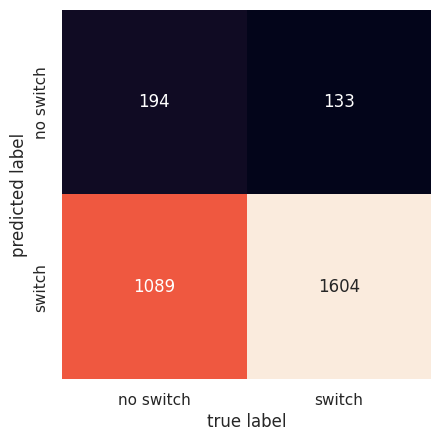

In [241]:
sns.heatmap(confusion_matrix(y, pred_switch_distance).T, square=True, annot=True, 
            cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [242]:
print(classification_report(y, pred_switch_distance, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.59      0.15      0.24      1283
      switch       0.60      0.92      0.72      1737

    accuracy                           0.60      3020
   macro avg       0.59      0.54      0.48      3020
weighted avg       0.59      0.60      0.52      3020



This model achieved an accuracy of 60%.

Regarding the "no switch" class:
- The precision of the model for this class was 59%, meaning that 59% of the instances predicted as "no switch" were accurately classified.
- The recall for the "no switch" class was 15%, indicating that only 15% of the actual "no switch" instances were correctly identified by the model.
- The f1-score, which combines precision and recall, for the "no switch" class was 0.24.


Regarding the "switch" class:
- The precision for the "switch" class was 60%, implying that 60% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 92%, meaning that the model accurately identified 92% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.72, representing the harmonic mean of precision and recall.

#### Fit a model with distance and arsenic as predictors

Fit the model and examine the coefficients.


In [243]:
X = df[['distance_100_meters', 'arsenic']]

In [244]:
log_reg_distance_arsenic = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.650773
         Iterations 5


In [245]:
print(log_reg_distance_arsenic.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3017
Method:                           MLE   Df Model:                            2
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.04551
Time:                        11:09:35   Log-Likelihood:                -1965.3
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 1.995e-41
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0027      0.079      0.035      0.972      -0.153       0.158
distance_100_meters    -0.8966      0.104     -8.593      0.000      -1.101      -0.692
arsenic         

All predictors except `const` are statistically significant due to their p-values. According to the pseudo r-squared value of 0.04551, this is a poor model.


$\rightarrow$ Why did the coefficient for `distance` change when arsenic was added?


There is a correlation between distance and arsenic concentration.

$\rightarrow$ Plot the decision boundary on a scatter plot of distance vs. arsenic, with point colored by switch.

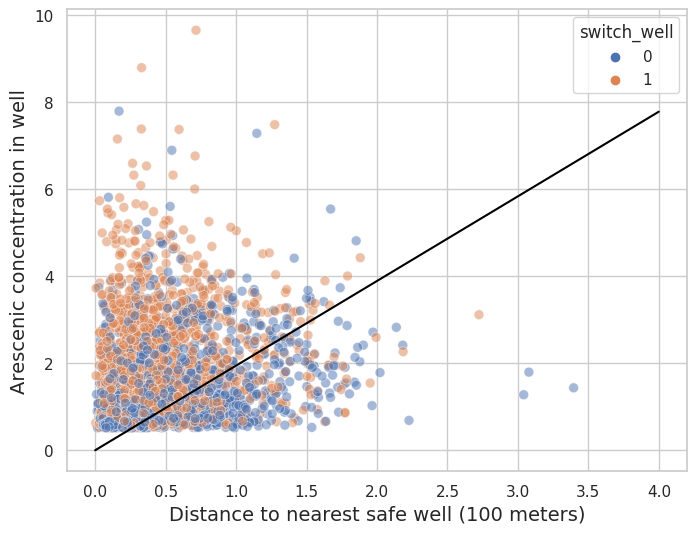

In [246]:
plt.figure(figsize = (8,6))

sns.scatterplot(data = df, x = 'distance_100_meters', y = 'arsenic', hue = 'switch_well', alpha = 0.5, s = 50);

a, b, c = log_reg_distance_arsenic.params.values
x_boundary = np.linspace(0,4,100)
y_boundary = (-a - b*x_boundary)/c

plt.plot(x_boundary, y_boundary, color = 'black')

plt.xlabel('Distance to nearest safe well (100 meters)', fontsize = 14)
plt.ylabel('Arescenic concentration in well', fontsize = 14);

People are less willing to switch wells if they live further away.

##### $\rightarrow$ Predict the well switching in the data

In [247]:
pred_switch_distance_arsenic = round(log_reg_distance_arsenic.predict(sm.add_constant(X)))

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

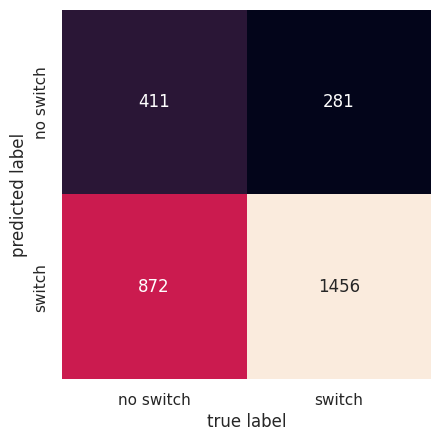

In [248]:
sns.heatmap(confusion_matrix(y, pred_switch_distance_arsenic).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [249]:
print(classification_report(y, pred_switch_distance_arsenic, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.59      0.32      0.42      1283
      switch       0.63      0.84      0.72      1737

    accuracy                           0.62      3020
   macro avg       0.61      0.58      0.57      3020
weighted avg       0.61      0.62      0.59      3020



In [250]:
print(classification_report(y, pred_switch, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.58      0.37      0.45      1283
      switch       0.63      0.80      0.71      1737

    accuracy                           0.62      3020
   macro avg       0.60      0.58      0.58      3020
weighted avg       0.61      0.62      0.60      3020



## Compare models

We will use logistic regression and XGBoost to construct models that predict the probability of switching wells.

To compare the different approaches, we will use a training and testing split of the data set.


##### $\rightarrow$ Create an input $X$ with all predictors.

In [251]:
X = df.drop(columns=['switch_well', 'distance_in_meters'])
y = df['switch_well']

In [252]:
X.head()

,arsenic,organization_member,education_years,distance_100_meters
0,2.36,0,0,0.16826
1,0.71,0,0,0.47322
2,2.07,0,10,0.20967
3,1.15,0,12,0.21486
4,1.10,1,14,0.40874


##### $\rightarrow$ Split the data into training and testing sets. Keep 20% of the data for the test set.

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [254]:
print(X_train.shape, X_test.shape)

(2416, 4) (604, 4)


##### $\rightarrow$ Check that the training and testing input numerical variables have similar means and standard deviations.

In [255]:
X_train.agg(['mean','std']).round(2)

,arsenic,organization_member,education_years,distance_100_meters
mean,1.68,0.43,4.84,0.49
std,1.12,0.49,4.02,0.39


In [256]:
X_test.agg(['mean','std']).round(2)

,arsenic,organization_member,education_years,distance_100_meters
mean,1.58,0.41,4.77,0.47
std,1.04,0.49,4.02,0.38


In [257]:
y_train.value_counts()

1    1392
0    1024
Name: switch_well, dtype: int64

In [258]:
y_test.value_counts()

1    345
0    259
Name: switch_well, dtype: int64

In [259]:
y_train.mean()

0.5761589403973509

In [260]:
y_test.mean()

0.5711920529801324

### Null model 

The null model prediction always predicts the value of `switch_well` that occurs most often in the training data.


$\rightarrow$ What is the null model prediction for `switch_well` based on the training data?


In [261]:
null_prediction = np.ones(np.shape(y_test))

In [262]:
y_train.value_counts()

1    1392
0    1024
Name: switch_well, dtype: int64

$\rightarrow$ What is the accuracy of the null model on the test data set?


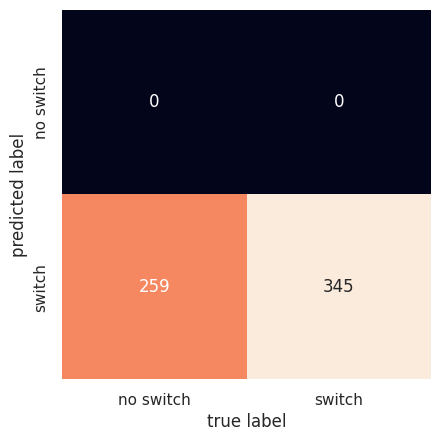

In [263]:
sns.heatmap(confusion_matrix(y_test, null_prediction).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [264]:
print(classification_report(y_test, null_prediction, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.00      0.00      0.00       259
      switch       0.57      1.00      0.73       345

    accuracy                           0.57       604
   macro avg       0.29      0.50      0.36       604
weighted avg       0.33      0.57      0.42       604



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The null prediction achieved an accuracy of 57%.

Regarding the "no switch" class:
- All values are 0.00 indicating the model failed to correctly identify instances belonging to the class.


Regarding the "switch" class:
- The precision for the "switch" class was 57%, implying that 57% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 100%, meaning that the model accurately identified 100% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.73, representing the harmonic mean of precision and recall.

### Logistic regression model


#### Logistic regression model for all predictors

##### $\rightarrow$ Fit the logistic regression model using all predictors, using the training data.

In [265]:
log_reg_all = sm.Logit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.643453
         Iterations 5


In [266]:
print(log_reg_all.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 2416
Model:                          Logit   Df Residuals:                     2411
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.05583
Time:                        11:09:36   Log-Likelihood:                -1554.6
converged:                       True   LL-Null:                       -1646.5
Covariance Type:            nonrobust   LLR p-value:                 1.110e-38
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1654      0.112     -1.479      0.139      -0.385       0.054
arsenic                 0.4782      0.046     10.307      0.000       0.387       0.569
organization_mem

##### $\rightarrow$ Predict the well switching in the test data.

In [267]:
pred_switch_log_reg = round(log_reg_all.predict(sm.add_constant(X_test)))

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

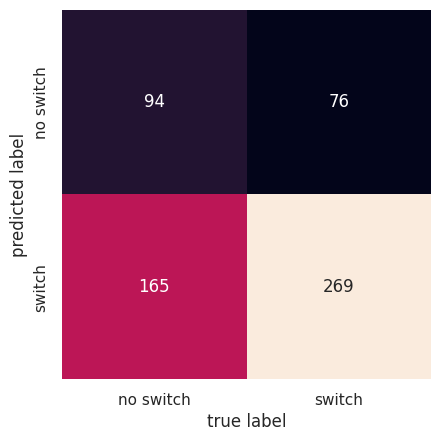

In [268]:
sns.heatmap(confusion_matrix(y_test, pred_switch_log_reg).T, 
            square=True, annot=True, cbar=False, fmt='g', 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy, sensitivity, and specificity.

In [269]:
print(classification_report(y_test, pred_switch_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.44       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.59      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



The logistic regression model achieved 60% accuracy.

Regarding the "no switch" class:
- The precision of the model for this class was 55%, meaning that 55% of the instances predicted as "no switch" were accurately classified.
- The recall for the "no switch" class was 36%, indicating that only 36% of the actual "no switch" instances were correctly identified by the model.
- The f1-score, which combines precision and recall, for the "no switch" class was 0.44.


Regarding the "switch" class:
- The precision for the "switch" class was 62%, implying that 62% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 78%, meaning that the model accurately identified 78% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.69, representing the harmonic mean of precision and recall.

The null prediction accuracy is 57% and the logistic regression model has a 60% accuracy. The logistic regression model is slightly better.

### XGBoost


Compare the model accuracy to an XGBoost model on the same train/test split.

$\rightarrow$ Use 5-fold cross-validation to determine the hyperparameters of the XGBoost model.


In [270]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),  
    "max_depth": randint(2, 6), 
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            n_iter=200, cv=5, verbose=1, 
                            n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb2935a3bb0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb2935a3a00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb2935a3190>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb2935a0520>},
                   return_train_score=True, verbose=1)

$\rightarrow$ Fit the model using the best parameters on the training data.

In [271]:
search.best_params_

{'colsample_bytree': 0.8607298531558665,
 'gamma': 0.4012844930219633,
 'learning_rate': 0.0407273422284632,
 'max_depth': 2,
 'n_estimators': 141,
 'subsample': 0.6015713340903892}

Setting best parameters to the XGBoost model.

In [272]:
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**search.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8607298531558665, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4012844930219633, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0407273422284632, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=141, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Fitting the XGBoost model to training data.

In [273]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8607298531558665, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4012844930219633, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0407273422284632, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=141, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

##### $\rightarrow$ Plot the feature importances using `gain` to determine importance.

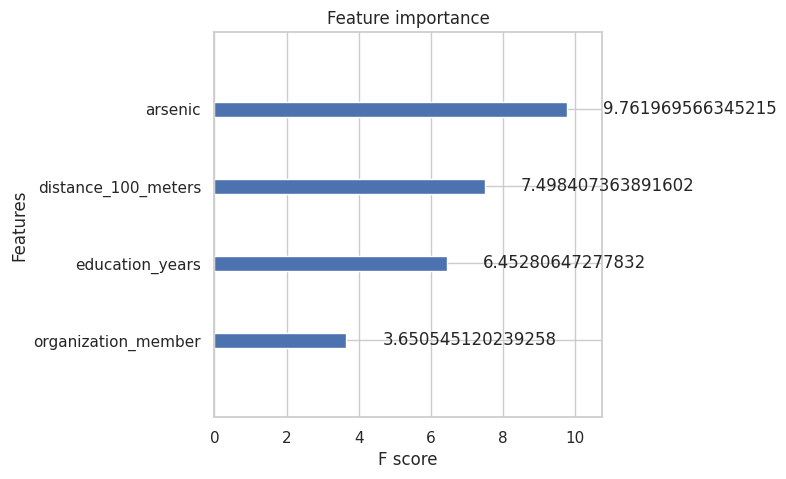

In [274]:
fig, ax = plt.subplots(figsize = (5,5))
xgb.plot_importance(xgb_model, ax = ax, importance_type='gain');

From the ouput, `arsenic` has the highest importance value at 9.762. This indicates that `arsenic` has the most impact on the XGBoost model predictions.

##### $\rightarrow$ Predict the well switching in the test data.

In [275]:
pred_mgb = xgb_model.predict(X_test)

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

In [276]:
mat_mgb = confusion_matrix(y_test, pred_mgb)

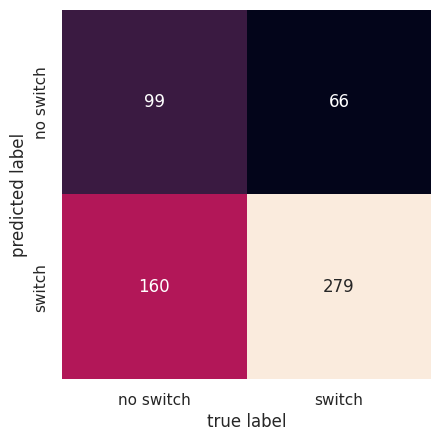

In [277]:
sns.heatmap(mat_mgb.T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy, sensitivity, and specificity.

In [278]:
xgb_model.score(X_test, y_test).round(2)

0.63

In [279]:
print(classification_report(y_test, pred_mgb, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.60      0.38      0.47       259
      switch       0.64      0.81      0.71       345

    accuracy                           0.63       604
   macro avg       0.62      0.60      0.59       604
weighted avg       0.62      0.63      0.61       604



The XGBoost model achieved an accuracy rate of 63% when predicting the classes "no switch" and "switch" using the provided test data.

Regarding the "no switch" class:
- The precision of the model for this class was 60%, meaning that 60% of the instances predicted as "no switch" were accurately classified.
- The recall for the "no switch" class was 38%, indicating that only 38% of the actual "no switch" instances were correctly identified by the model.
- The f1-score, which combines precision and recall, for the "no switch" class was 0.47.


Regarding the "switch" class:

- The precision for the "switch" class was 64%, implying that 64% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 81%, meaning that the model accurately identified 81% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.71, representing the harmonic mean of precision and recall.

### Test different models

##### $\rightarrow$ Try to improve the prediction accuracy by either transforming the input variables, using a different model, or both.

Creating a ridge logistic regression model, then fitting it to the training data, and predicting the classes for the testing data.

In [281]:
ridge_log_reg = LogisticRegression(penalty='l2', solver='liblinear')
ridge_log_reg.fit(X_train, y_train)
pred_ridge_log_reg = ridge_log_reg.predict(X_test)

In [282]:
print(classification_report(y_test, pred_ridge_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.44       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.59      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



The ridge logistic regression model achieved 60% accuracy.

Regarding the "no switch" class:
- The precision of the model for this class was 55%, meaning that 55% of the instances predicted as "no switch" were accurately classified.
- The recall for the "no switch" class was 36%, indicating that only 36% of the actual "no switch" instances were correctly identified by the model.
- The f1-score, which combines precision and recall, for the "no switch" class was 0.44.


Regarding the "switch" class:
- The precision for the "switch" class was 62%, implying that 62% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 78%, meaning that the model accurately identified 78% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.69, representing the harmonic mean of precision and recall.

Fitting the logisitic regression model using a l1 penalty.

In [283]:
log_reg_lasso = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_lasso.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

Getting the coefficients and feature names.

In [284]:
coefficients = log_reg_lasso.coef_.ravel()
feature_names = X_train.columns

Creating new dataframe using coefficients and feature names and plot them to visualize variable importance.

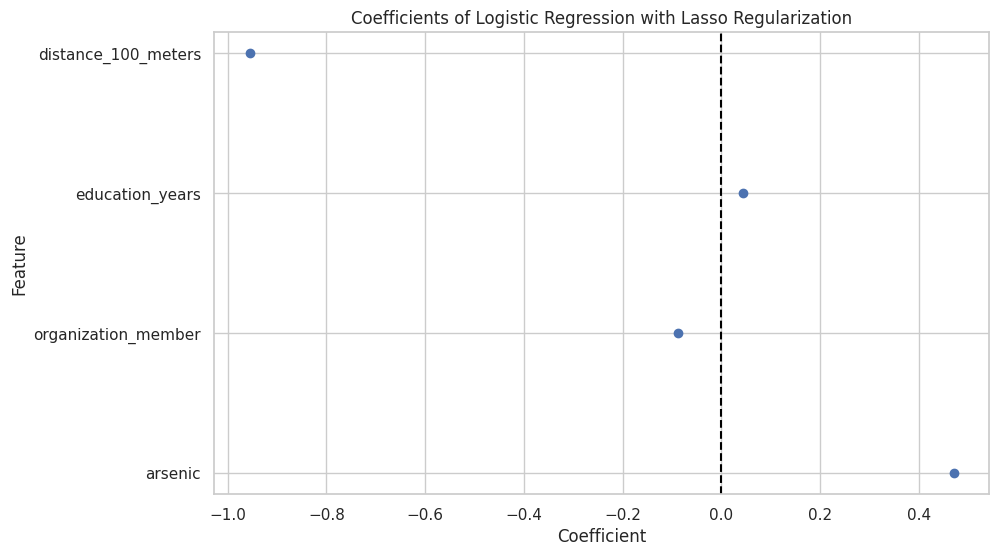

In [290]:
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

plt.figure(figsize=(10, 6))
plt.scatter(coef_df['Coefficient'], coef_df['Feature'])
plt.axvline(x=0, color='black', linestyle='--')
plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.title('Coefficients of Logistic Regression with Lasso Regularization')
plt.show()

 Important variables: `distance_100_meters`, `education_years`, `organization_member`, and `arsenic`.

Doing a 5-fold cross validation to find the best alpha.



In [286]:
lassocv = LassoCV(alphas=None, cv=5, max_iter=100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.00016388261479759653

The cross validation indicates this is a strong model because its alpha value is 0.00016.

Fitting the lasso model on the training data.

In [287]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)

Using lasso model to predict the testing data. Then compute the mean squared error, root mean squared error, and r-squared values.

In [288]:
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 0.235  RMSE = 0.485  R-squared = 0.04


Both MSE and RMSE have lower values, indicating a better fit.

In [289]:
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear')
lasso_log_reg.fit(X_train, y_train)
pred_lasso_log_reg = lasso_log_reg.predict(X_test)

print(classification_report(y_test, pred_lasso_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.43       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.58      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



The lasso logistic regression model achieved 60% accuracy.

Regarding the "no switch" class:
- The precision of the model for this class was 55%, meaning that 55% of the instances predicted as "no switch" were accurately classified.
- The recall for the "no switch" class was 36%, indicating that only 36% of the actual "no switch" instances were correctly identified by the model.
- The f1-score, which combines precision and recall, for the "no switch" class was 0.43.


Regarding the "switch" class:
- The precision for the "switch" class was 62%, implying that 62% of the instances predicted as "switch" were correctly classified.
- The recall for the "switch" class was 78%, meaning that the model accurately identified 78% of the actual "switch" instances.
- The f1-score for the "switch" class was 0.69, representing the harmonic mean of precision and recall.

# Conclusion

We wanted to investigate how accurately we can predict whether or not a household will switch wells based on environmental variables. After our analysis using different models to predict household behavior we are able to summarize key points.

Logistic regression achieved an accuracy of 60% where `switch` had higher precision. XGBoost achieved an accuracy of 62% where `switch` also had higher precision and recall. Lasso regression achieved 60% accuracy similarily to ridge regression. When predicting well switching behavior, distance to nearest well, education years, organization member, and arsenic were the most important variables.

Overall, the models achieved an accuracy of 60% in predicting well switching behaviour. XGBoost was the best model with an accuracy of 62%. Through our analysis, we were able to determine factors that can influence household decisions on well switching.
